## Final Project Submission

Please fill out:
* Student name: Blake McMeekin
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Claude Fried
* Blog post URL:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit, train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

import folium
import folium.plugins
from folium import IFrame

import branca
import branca.colormap as cm

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data/kc_house_data.csv')

# The Plan

Predicting price will be the aim of this model, and I think the way we'll tackle that is to start with a kitchen-sink model to view all of the data and relationships and then create a few iterations to simplify the model.

To do this, we'll start with some EDA and then split the data into numeric, categorical, and spatial data for cleanup, and then recombine the data for our analysis and model building.

# EDA
Let's get a feel for this dataset and determine where our cleanup efforts and attention should go.

In [2]:
data

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0          5650     1.0        NaN  NONE  ...      7 Average       1180   
1          7242     2.0         NO  NONE  ...      7 Average       2170   
2         10000     1.0         NO  NONE  ...  6 Low Average        770   
3          5000     1.0         NO  NONE  ...      7 Average       1050   
4          8080     1.0         NO  NONE  ...         8 Good       1680   
...         ...     ...        ...   ...  ...            ...        ...   
21592      1131     3.0         NO  NONE  ...         8 Good       1530   
21593      5813     2.0         NO  NONE  ...         8 Good       2310   
21594      1350     2.0         NO  NONE  ...      7 Average       1020   
21595      2388     2.0        NaN  NONE  ...         8 Good       1600   
21596      1076     2.0         NO  NONE  ...      7 Average       1020   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0                0.0     1955           0.0    98178  47.5112 -122.257   
1              400.0     1951        1991.0    98125  47.7210 -122.319   
2                0.0     1933           NaN    98028  47.7379 -122.233   
3              910.0     1965           0.0    98136  47.5208 -122.393   
4                0.0     1987           0.0    98074  47.6168 -122.045   
...              ...      ...           ...      ...      ...      ...   
21592            0.0     2009           0.0    98103  47.6993 -122.346   
21593            0.0     2014           0.0    98146  47.5107 -122.362   
21594            0.0     2009           0.0    98144  47.5944 -122.299   
21595            0.0     2004           0.0    98027  47.5345 -122.069   
21596            0.0     2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21597 rows x 21 columns]

In [3]:
data.info() # There are some missing values here, especially in view and waterfront. Yr Renovated could be filled w/ yr blt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
### Filling empty values
data['waterfront'] = data['waterfront'].fillna(value='DUNNO')
data['yr_renovated'] = data['yr_renovated'].fillna(value=data['yr_built'])
mask = (data['yr_renovated'] == 0)
data['yr_renovated'][mask] = data['yr_built'][mask] # there will be lots of correlation between yr_ren and yr_blt
data['view'] = data['view'].fillna(value='DUNNO')

In [5]:
# data.sample(25)[['yr_built', 'yr_renovated']]
# data.sample(25)[['waterfront']]
# data.sample(25)[['view']]

data.info() # all better?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  object 
 9   view           21597 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
data.describe() # This description of numeric values looks quite clean

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    sqft_above      yr_built  yr_renovated  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  21597.000000   
mean   1.509941e+04      1.494096   1788.596842   1970.999676   1972.945131   
std    4.141264e+04      0.539683    827.759761     29.375234     28.945393   
min    5.200000e+02      1.000000    370.000000   1900.000000   1900.000000   
25%    5.040000e+03      1.000000   1190.000000   1951.000000   1954.000000   
50%    7.618000e+03      1.500000   1560.000000   1975.000000   1977.000000   
75%    1.068500e+04      2.000000   2210.000000   1997.000000   1999.000000   
max    1.651359e+06      3.500000   9410.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000  21597.000000   21597.000000   21597.000000  
mean   98077.951845     47.560093   -122.213982    1986.620318   12758.283512  
std       53.513072      0.138552      0.140724     685.230472   27274.441950  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471100   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.231000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [7]:
### Dropping duplicate rows
data = data.loc[data.duplicated('id') == False]

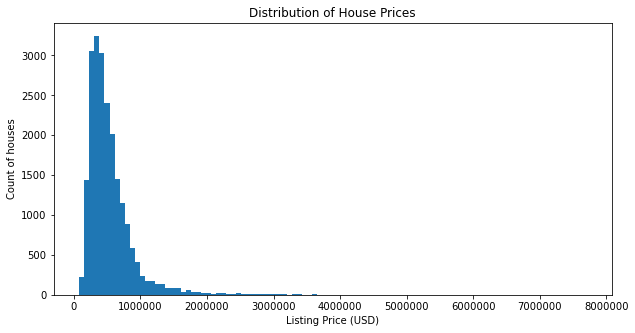

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(data['price'], bins=100)

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Listing Price (USD)")
ax.set_ylabel("Count of houses")
ax.set_title("Distribution of House Prices");

Initial thoughts:
My gut tells me square footage, bedrooms/bathrooms, waterfront, view, and condition will all play relevant parts in predicting the price. Following these, we may see correlations in floors, year built/renovated, and zipcode. We'll keep that in mind.

## Numeric Data and Log Transformation

In [9]:
# Splitting out numeric data

numeric = data[['price', 'sqft_living', 'sqft_lot', 'yr_built', 'yr_renovated', 'bedrooms', 'bathrooms', 'floors']]
log_numeric = np.log(numeric)

# switch downstream between log_numeric/numeric
numericformat = log_numeric

### Normalization
# from scipy import stats
# Y_norm = pd.Series(stats.zscore(y_train), name=y_train.name)
# Y_norm.head(5)

## Categorical Data

In [10]:
### Splitting out categorical data
# Subset the DataFrame - droppable columns: 
# ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
# categories = ['bedrooms', 'bathrooms', 'floors', 'view', 'waterfront', 'grade', 'condition']

In [11]:
### Splitting out categorical data

categories = data[['view', 'waterfront', 'grade', 'condition']]

# Making dummy columns for categorical data
view = pd.get_dummies(data['view'], prefix='view', drop_first=True)
waterfront = pd.get_dummies(data['waterfront'], prefix='waterfront', drop_first=True)
grade = pd.get_dummies(data['grade'], prefix='grade', drop_first=True)
condition = pd.get_dummies(data['condition'], prefix='condition', drop_first=True)

categorical = pd.concat([view, waterfront, grade, condition], axis=1)

# log_processed = data.drop(categories, axis=1)
# preprocessed = pd.concat([numeric, dummies], axis=1)

## Spatial Data
There's a lot of information in zipcode and lat/long that may be useful for model predictions, but in its basic form it's hard for a model to digest. Maybe we can reformat some of this data to show us price predictions just based on location?

In [12]:
### Zipcode categorization
spatial = pd.get_dummies(data['zipcode'].astype(str), drop_first=True) # initializing spatial df

### Combining categorized zipcodes with lat/long and collecting a baseline
spatial[['lat', 'long']] = data[['lat', 'long']]

### adding in price
spatial.head(2) # peeping df of all spatial data

98002  98003  98004  98005  98006  98007  98008  98010  98011  98014  ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   

   98155  98166  98168  98177  98178  98188  98198  98199      lat     long  
0      0      0      0      0      1      0      0      0  47.5112 -122.257  
1      0      0      0      0      0      0      0      0  47.7210 -122.319  

[2 rows x 71 columns]

## Consolidating Data

In [13]:
### Combining numeric, categorical and spatial data
processed = pd.concat([numericformat, categorical, spatial], axis=1)

# Analysis and Model Building

### Train/Test Split

In [14]:
### Split data into 75-25 train-test split 
X = processed.drop(['price', 'lat', 'long'], axis=1)
y = processed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

### K-Fold Baseline

In [15]:
# K-fold validation
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
regression = LinearRegression()

baseline_scores = cross_validate(
    estimator=regression,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.8816056669101112
Validation score: 0.8772870442510572


## Pre-Model Visualizations

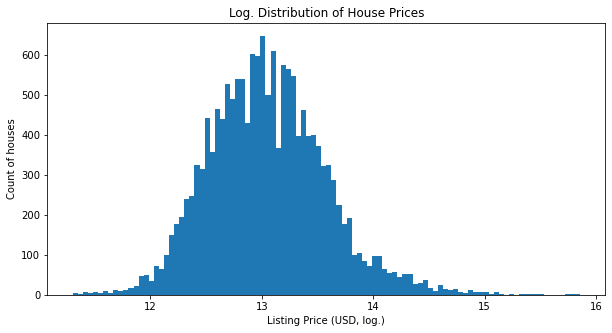

In [16]:
# Histogram for Price Distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_train, bins=100)


ax.set_xlabel("Listing Price (USD, log.)")
ax.set_ylabel("Count of houses")
ax.set_title("Log. Distribution of House Prices");

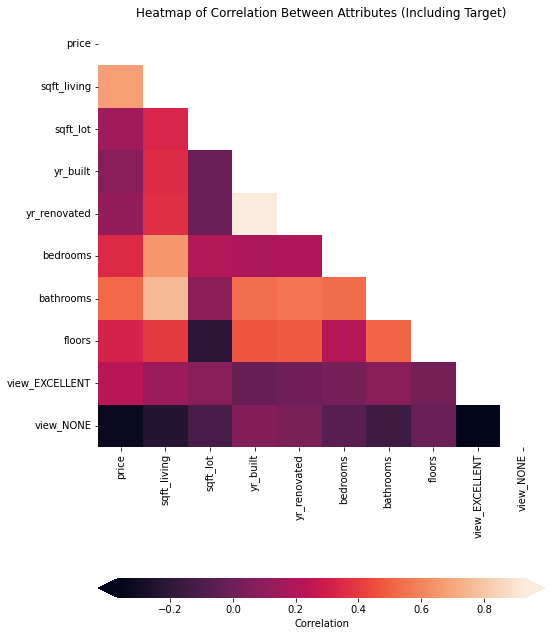

In [17]:
### Correlation Matrix

# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([y_train, X_train[['sqft_living', 
                                            'sqft_lot', 
                                            'yr_built', 
                                            'yr_renovated', 
                                            'bedrooms', 
                                            'bathrooms', 
                                            'floors',
                                            'view_EXCELLENT', 
                                            'view_NONE']]], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(8, 12))

### Plot a heatmap of the correlation matrix, with both numbers and colors indicating the correlations
sns.heatmap(
    data=corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    ax=ax,
    # Specifies that we want labels, not just colors
    # annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Plot description
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

Looking at this correlation matrix, it seems that sqft_living, bathrooms, bedrooms, and floors (in that order) meaningfully correlate with price.

### Spatial Data Visualizations

There's a lot of information in zipcode and lat/long that may be useful for model predictions, but in its basic form it's hard for a model to digest. Maybe we can reformat some of this data to show us price predictions just based on location?

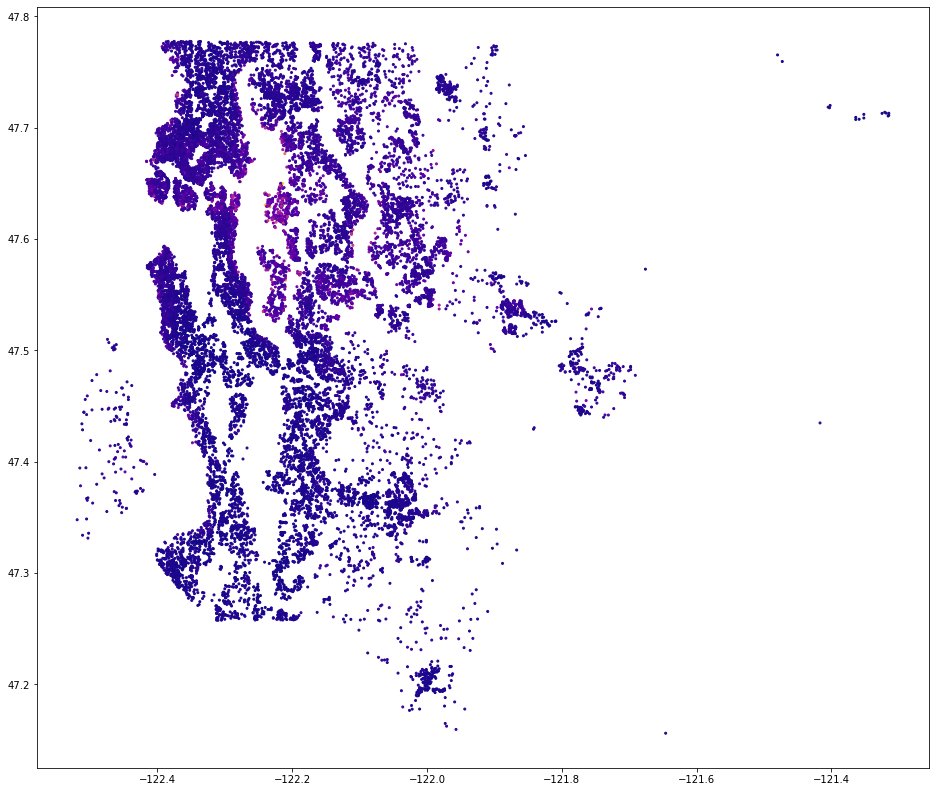

In [18]:
# # ### Price of data map
# plt.figure(figsize=(16, 14))
# plt.scatter(data['long'], data['lat'], marker='o', c=data['price'], s=4, cmap='plasma');

It's obvious by looking at this map of prices, there is some sort of meaningful relationship between location and price.

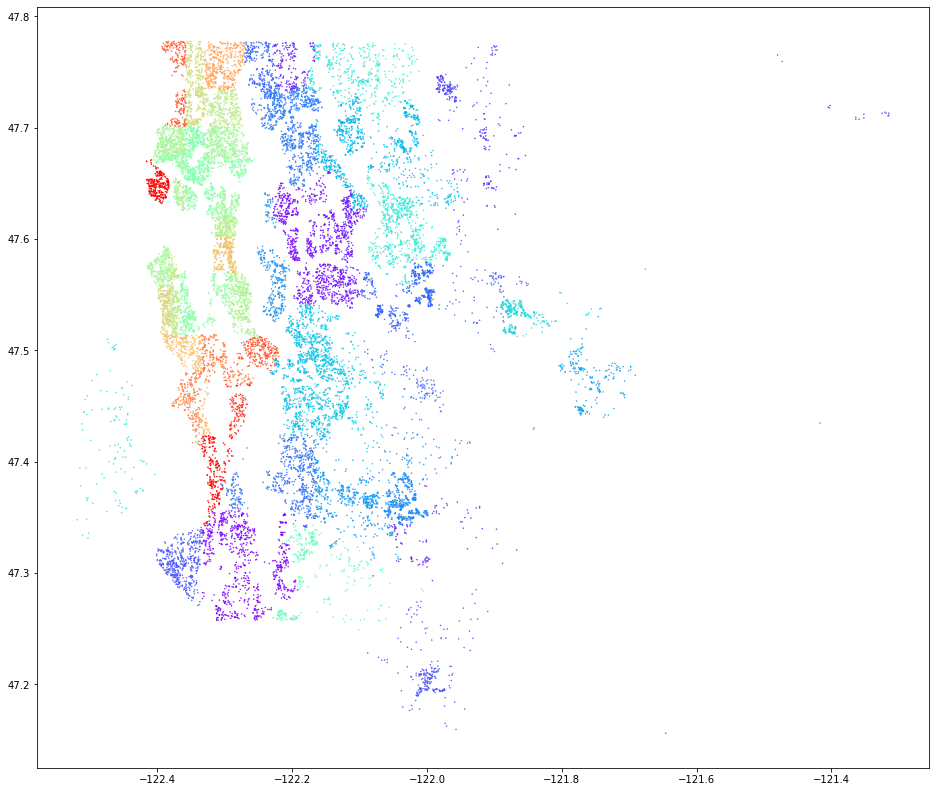

In [19]:
# # ### Zipcode Map
# plt.figure(figsize=(16, 14))
# plt.scatter(data['long'], data['lat'], marker='.', c=data['zipcode'], s=1, cmap='rainbow');

We can also see that zipcodes might describe some of this information, but appear to lose a lot of resolution

# Kitchen-sink Multiple Linear Regression

In [20]:
import statsmodels.api as sm

### OLS multi-linear regression

X_train_1 = sm.add_constant(X_train) # Adding constant
model = sm.OLS(y_train, X_train_1) # defining model parameters
results = model.fit() # Fitting model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1230.
Date:                Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:44:07   Log-Likelihood:                 4609.1
No. Observations:               16065   AIC:                            -9024.
Df Residuals:                   15968   BIC:                            -8279.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.4571      1.337     10.810      0.000      11.836      17.078
sqft_living             0.4304      0.008     56.797      0.000       0.416       0.445
sqft_lot                0.0665      0.002     27.670      0.000       0.062       0.071
yr_built               -2.6177      0.277     -9.440      0.000      -3.161      -2.074
yr_renovated            1.9078      0.278      6.857      0.000       1.362       2.453
bedrooms               -0.0420      0.007     -5.886      0.000      -0.056      -0.028
bathrooms               0.0512      0.007      7.541      0.000       0.038       0.065
floors                  0.0266      0.006      4.638      0.000       0.015       0.038
view_DUNNO             -0.0655      0.027     -2.449      0.014      -0.118      -0.013
view_EXCELLENT          0.1975      0.016     12.148      0.000       0.166       0.229
view_FAIR               0.0115      0.014      0.850      0.395      -0.015       0.038
view_GOOD               0.0791      0.012      6.821      0.000       0.056       0.102
view_NONE              -0.1119      0.007    -15.296      0.000      -0.126      -0.098
waterfront_NO           0.0025      0.005      0.539      0.590      -0.007       0.012
waterfront_YES          0.4482      0.022     20.344      0.000       0.405       0.491
grade_11 Excellent      0.1420      0.012     11.574      0.000       0.118       0.166
grade_12 Luxury         0.2899      0.022     12.897      0.000       0.246       0.334
grade_13 Mansion        0.5840      0.056     10.463      0.000       0.475       0.693
grade_3 Poor         1.006e-13    1.1e-14      9.141      0.000    7.91e-14    1.22e-13
grade_4 Low            -0.5165      0.047    -10.917      0.000      -0.609      -0.424
grade_5 Fair           -0.5258      0.017    -30.108      0.000      -0.560      -0.492
grade_6 Low Average    -0.4296      0.011    -39.249      0.000      -0.451      -0.408
grade_7 Average        -0.3489      0.009    -40.663      0.000      -0.366      -0.332
grade_8 Good           -0.2461      0.008    -32.058      0.000      -0.261      -0.231
grade_9 Better         -0.1015      0.008    -13.202      0.000      -0.117      -0.086
condition_Fair         -0.1360      0.017     -7.923      0.000      -0.170      -0.102
condition_Good          0.0308      0.004      8.179      0.000       0.023       0.038
condition_Poor         -0.3261      0.038     -8.667      0.000      -0.400      -0.252
condition_Very Good     0.0910      0.006     15.386      0.000       0.079       0.103
98002                  -0.0247      0.019     -1.303      0.193      -0.062       0.012
98003                   0.0162      0.017      0.947      0.344      -0.017       0.050
98004                   1.1203      0.017     67.870      0.000       1.088       1.153
980

This is a good looking R2 value, but the Jarque-Bera is telling us the data is not normally distributed and the high condition number suggests strong multicolinearity. Let's check this multicollinearity with a VIF test.

In [21]:
### VIF test
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_1.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_1.values, i)
                          for i in range(len(X_train_1.columns))]
  
# Looking at the top ten multicollinear values
vif_data.sort_values(by='VIF', ascending=False).head(10)

feature            VIF
0                 const  865832.786142
22      grade_7 Average       8.652488
3              yr_built       8.258055
4          yr_renovated       8.081484
23         grade_8 Good       5.754659
1           sqft_living       5.021688
21  grade_6 Low Average       4.853242
6             bathrooms       3.451187
24       grade_9 Better       3.086660
70                98103       2.824291

It looks like we do have some multicollinearity - in our next iteration we will drop some of these columns.

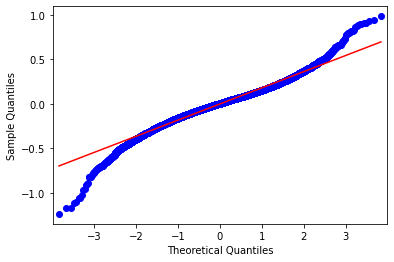

In [22]:
# Here is the QQ plot showing the distribution of data - we can see that the edges appear less normally distributed
sm.qqplot(results.resid, line='s');

This assumption fits in the middle, but not at the outer extremes - we see higher values at higher theoretical quantiles, and lower values at lower theoretical quantiles.

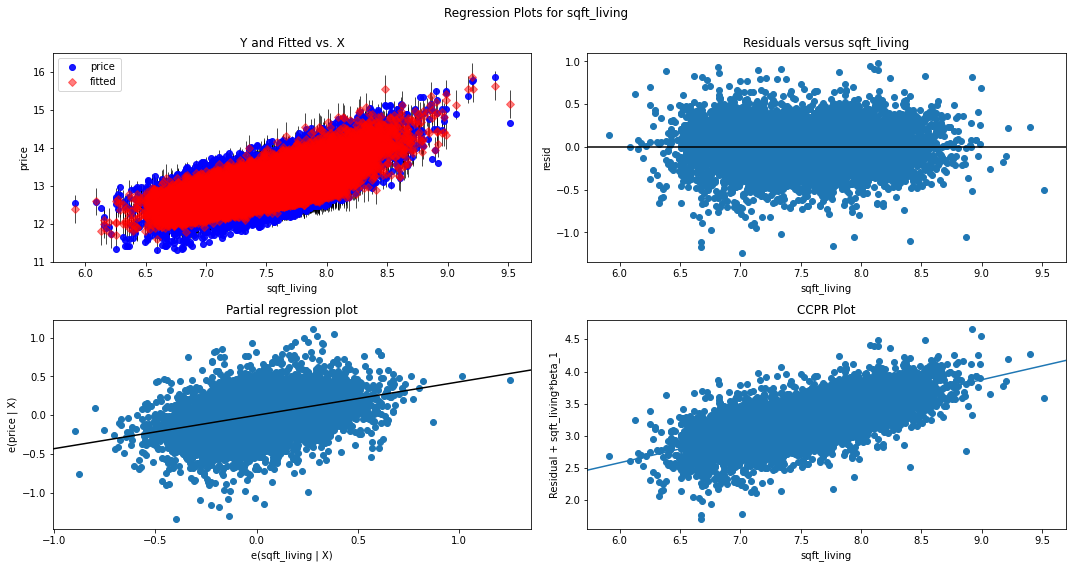

In [23]:
# Let's look at the results for sqft_living
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(results, 'sqft_living', fig=fig)
# This is pretty homoscedastic

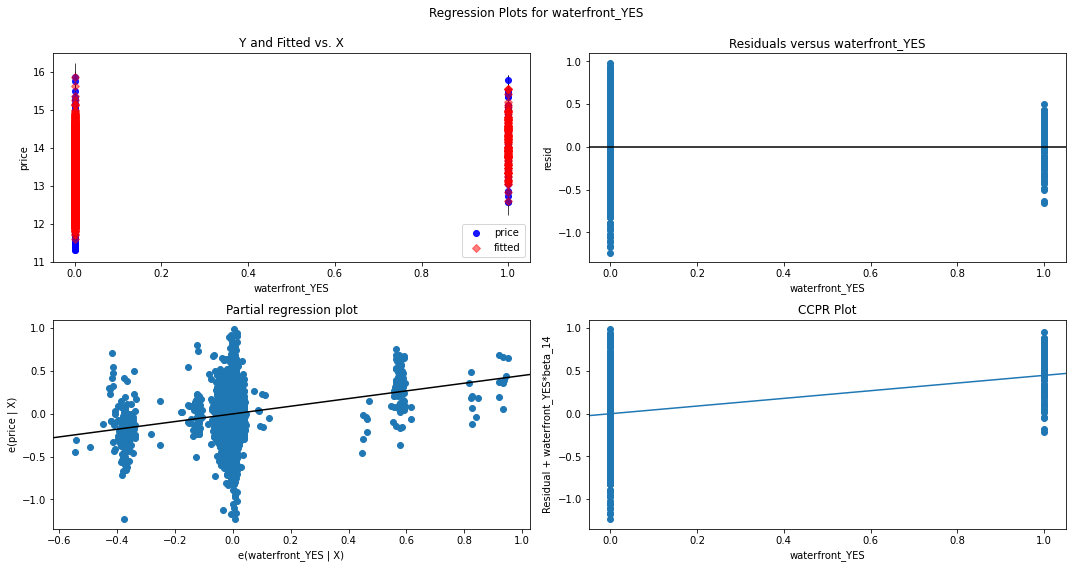

In [24]:
# Let's try a categorical variable
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(results, 'waterfront_YES', fig=fig)
# For categoric data it,s a little tricky, but this is loosely homoscedastic

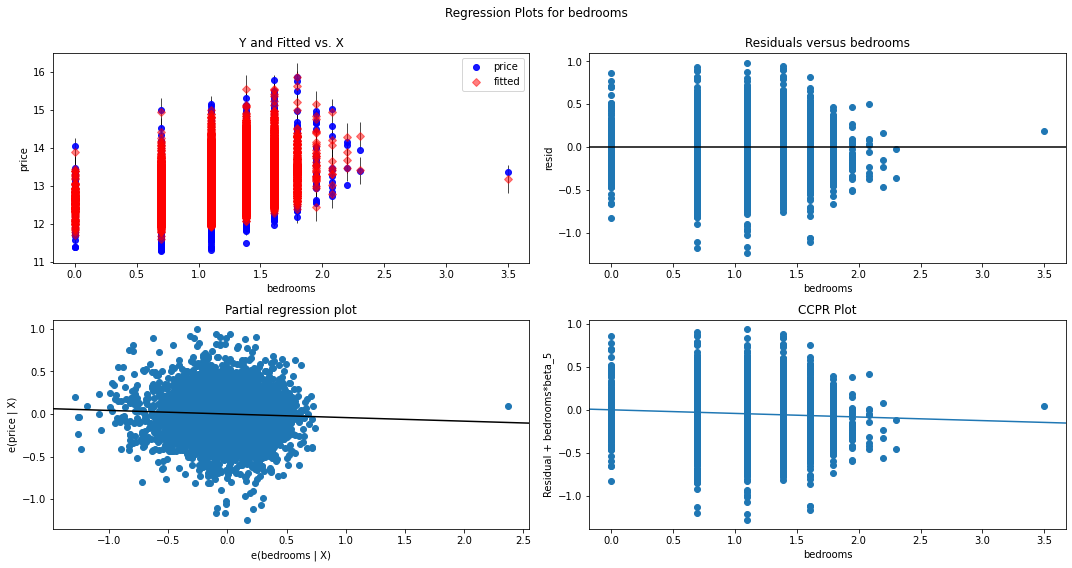

In [25]:
# Let's look at one of the more controversial predictors
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(results, 'bedrooms', fig=fig)
# The bedrooms data is a bit heteroscedastic

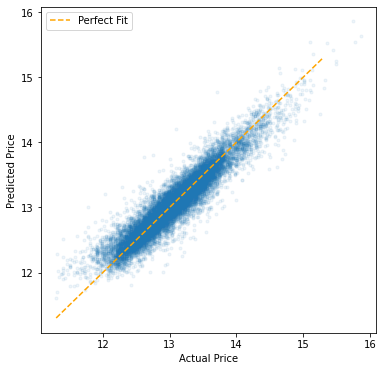

In [26]:
### Model prediction vs actual
preds = results.predict(X_train_1)
plt.figure(figsize=(6, 6))

perfect_line = np.arange(y_train.min(), y_train.max())

plt.plot(perfect_line, perfect_line, linestyle="--", color="orange", label="Perfect Fit")
plt.scatter(y_train, preds, alpha=0.07, marker='.')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend();

## Multi-Linear-Regression, iteration 2

Let's drop some of the collinear columns and some columns with high p-values

In [27]:
### Data Changes
X_train_2 = X_train_1.drop(['bathrooms', 
                          'yr_renovated',
                          'grade_3 Poor',
                          'grade_7 Average', # Impact on R2
                          'grade_8 Good',
                          'view_NONE', 
                          'view_DUNNO',
                          '98002',
                          '98023',
                          'waterfront_NO',
                          '98032',
                          'yr_built',
                          'sqft_lot', # Impact on R2
                          'condition_Good'], axis=1)
training_data = X_train_2

In [28]:
model = sm.OLS(y_train, training_data) # defining model parameters
results = model.fit() # Fitting model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     1143.
Date:                Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:44:16   Log-Likelihood:                 3074.4
No. Observations:               16065   AIC:                            -5981.
Df Residuals:                   15981   BIC:                            -5335.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.7044      0.043    177.115      0.000       7.619       7.790
sqft_living             0.6508      0.006    102.251      0.000       0.638       0.663
bedrooms               -0.0930      0.008    -12.152      0.000      -0.108      -0.078
floors                  0.0100      0.005      1.875      0.061      -0.000       0.021
view_EXCELLENT          0.3482      0.017     21.020      0.000       0.316       0.381
view_FAIR               0.1224      0.013      9.370      0.000       0.097       0.148
view_GOOD               0.2187      0.011     20.478      0.000       0.198       0.240
waterfront_YES          0.4516      0.024     18.952      0.000       0.405       0.498
grade_11 Excellent      0.3101      0.012     24.895      0.000       0.286       0.335
grade_12 Luxury         0.4455      0.024     18.392      0.000       0.398       0.493
grade_13 Mansion        0.7212      0.061     11.786      0.000       0.601       0.841
grade_4 Low            -0.0523      0.051     -1.032      0.302      -0.152       0.047
grade_5 Fair           -0.1092      0.016     -6.970      0.000      -0.140      -0.078
grade_6 Low Average    -0.0540      0.006     -8.628      0.000      -0.066      -0.042
grade_9 Better          0.1162      0.005     21.704      0.000       0.106       0.127
condition_Fair         -0.1285      0.019     -6.852      0.000      -0.165      -0.092
condition_Poor         -0.3261      0.041     -7.897      0.000      -0.407      -0.245
condition_Very Good     0.0735      0.006     12.247      0.000       0.062       0.085
98003                   0.0470      0.016      2.999      0.003       0.016       0.078
98004                   1.1879      0.015     80.252      0.000       1.159       1.217
98005                   0.8261      0.018     44.975      0.000       0.790       0.862
98006                   0.7247      0.013     57.703      0.000       0.700       0.749
98007                   0.7167      0.021     34.429      0.000       0.676       0.758
98008                   0.6806      0.016     43.907      0.000       0.650       0.711
98010                   0.2957      0.024     12.170      0.000       0.248       0.343
98011                   0.4626      0.018     25.830      0.000       0.428       0.498
98014                   0.3423      0.023     15.137      0.000       0.298       0.387
98019                   0.3529      0.018     19.735      0.000       0.318       0.388
98022                   0.1213      0.017      7.269      0.000       0.089       0.154
98024                   0.5141      0.027     18.879      0.000       0.461       0.568
98027                   0.5719      0.013     43.130      0.000       0.546       0.598
98028                   0.4292      0.015     28.174      0.000       0.399       0.459
980

In [29]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = training_data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(training_data.values, i) for i in range(len(training_data.columns))]
  
# Looking at the top ten multicollinear values
vif_data.sort_values(by='VIF', ascending=False).head(10)

feature         VIF
0            const  757.306551
1      sqft_living    2.928947
2         bedrooms    1.855124
4   view_EXCELLENT    1.589805
7   waterfront_YES    1.559486
56           98103    1.509064
37           98038    1.502899
63           98115    1.472386
42           98052    1.471216
21           98006    1.450550

This VIF is looking a lot better - we should have much less multicollinearity

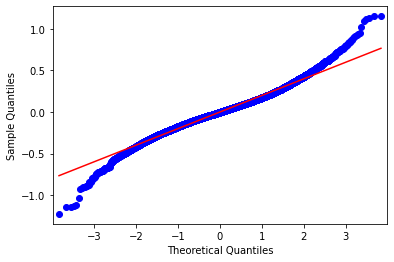

In [30]:
# QQ plot showing the distribution of data - not much has changed here
sm.qqplot(results.resid, line='s');

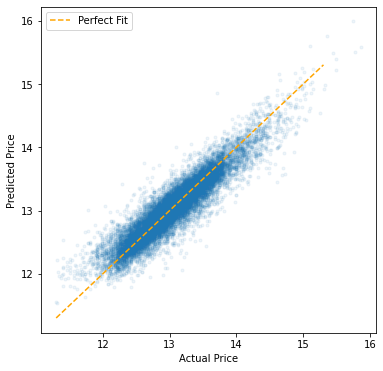

In [31]:
### Model prediction vs actual - this looks mostly the same
preds = results.predict(training_data)
plt.figure(figsize=(6, 6))

perfect_line = np.arange(y_train.min(), y_train.max())

plt.plot(perfect_line, perfect_line, linestyle="--", color="orange", label="Perfect Fit")
plt.scatter(y_train, preds, alpha=0.07, marker='.')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend();

## Multi-Linear-Regression, iteration 3

Let's keep dropping columns that appear to have minimal impact on the model prediction

In [32]:
### Data Changes
X_train_3 = X_train_2.drop(['floors', 
                            '98198', 
                            '98003', 
                            '98168', 
                            '98092', 
                            '98188',
                            '98030',
                            '98042',
                            '98022',
                            'grade_4 Low', 
                            'grade_6 Low Average', 
                            'grade_5 Fair'], axis=1)
training_data = X_train_3

In [33]:
model = sm.OLS(y_train, training_data) # defining model parameters
results = model.fit() # Fitting model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     1316.
Date:                Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:44:20   Log-Likelihood:                 2966.9
No. Observations:               16065   AIC:                            -5790.
Df Residuals:                   15993   BIC:                            -5237.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.5744      0.039    193.467      0.000       7.498       7.651
sqft_living             0.6739      0.006    114.337      0.000       0.662       0.685
bedrooms               -0.0915      0.008    -11.912      0.000      -0.107      -0.076
view_EXCELLENT          0.3452      0.017     20.735      0.000       0.313       0.378
view_FAIR               0.1204      0.013      9.189      0.000       0.095       0.146
view_GOOD               0.2202      0.011     20.601      0.000       0.199       0.241
waterfront_YES          0.4502      0.024     18.783      0.000       0.403       0.497
grade_11 Excellent      0.3000      0.012     24.061      0.000       0.276       0.324
grade_12 Luxury         0.4312      0.024     17.727      0.000       0.383       0.479
grade_13 Mansion        0.6987      0.062     11.355      0.000       0.578       0.819
grade_9 Better          0.1151      0.005     21.608      0.000       0.105       0.126
condition_Fair         -0.1436      0.019     -7.637      0.000      -0.180      -0.107
condition_Poor         -0.3636      0.041     -8.789      0.000      -0.445      -0.282
condition_Very Good     0.0695      0.006     11.659      0.000       0.058       0.081
98004                   1.1384      0.014     82.533      0.000       1.111       1.165
98005                   0.7778      0.018     44.225      0.000       0.743       0.812
98006                   0.6765      0.011     59.802      0.000       0.654       0.699
98007                   0.6727      0.020     33.330      0.000       0.633       0.712
98008                   0.6338      0.015     43.615      0.000       0.605       0.662
98010                   0.2381      0.024     10.013      0.000       0.191       0.285
98011                   0.4167      0.017     24.330      0.000       0.383       0.450
98014                   0.2835      0.022     12.875      0.000       0.240       0.327
98019                   0.3038      0.017     17.796      0.000       0.270       0.337
98024                   0.4553      0.027     16.991      0.000       0.403       0.508
98027                   0.5236      0.012     43.299      0.000       0.500       0.547
98028                   0.3836      0.014     26.897      0.000       0.356       0.412
98029                   0.5959      0.014     43.493      0.000       0.569       0.623
98031                   0.0428      0.015      2.892      0.004       0.014       0.072
98033                   0.7884      0.012     67.715      0.000       0.766       0.811
98034                   0.5048      0.011     47.040      0.000       0.484       0.526
98038                   0.1439      0.010     13.972      0.000       0.124       0.164
98039                   1.3354      0.033     40.160      0.000       1.270       1.401
980

In [34]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = training_data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(training_data.values, i) for i in range(len(training_data.columns))]
  
# Looking at the top ten multicollinear values
vif_data.sort_values(by='VIF', ascending=False).head(10)

feature         VIF
0                const  605.750253
1          sqft_living    2.479647
2             bedrooms    1.845320
3       view_EXCELLENT    1.585409
6       waterfront_YES    1.557644
10      grade_9 Better    1.208994
16               98006    1.161979
7   grade_11 Excellent    1.155173
34               98052    1.149252
30               98038    1.148998

This VIF is still looking quite good

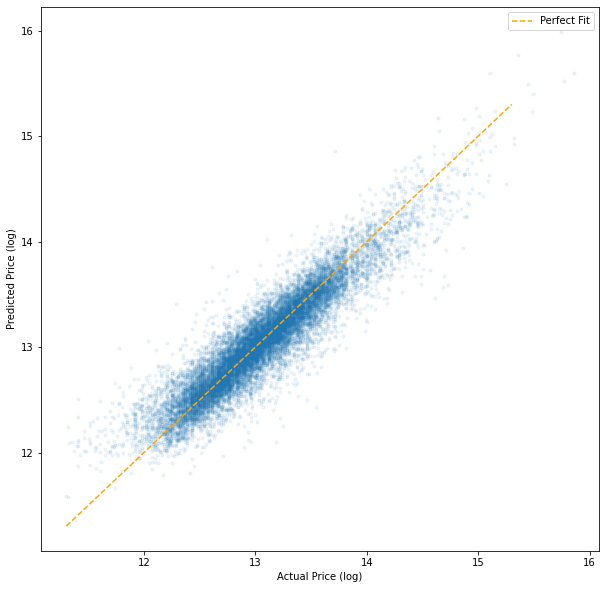

In [35]:
### Model prediction vs actual
preds = results.predict(training_data)
plt.figure(figsize=(10, 10))

perfect_line = np.arange(y_train.min(), y_train.max())

plt.plot(perfect_line, perfect_line, linestyle="--", color="orange", label="Perfect Fit")
plt.scatter(y_train, preds, alpha=0.07, marker='.')
plt.xlabel("Actual Price (log)")
plt.ylabel("Predicted Price (log)")
plt.legend();

With this iteration we've removed some model complexity and redundancy while keeping the R value pretty consistent.

## Model Validation

Here we will apply the linear regression model to our test data and see how it performs on information it has never seen. This will show us what degree of overfitting we may be seeing.

In [36]:
### Data Changes
dropped_columns = [      'bathrooms', 
                         'yr_renovated', 
                         'grade_7 Average',
                         'grade_8 Good',
                         'view_NONE', 
                         'view_DUNNO',
                         '98002',
                         '98023',
                         'waterfront_NO',
                         '98032',
                         'yr_built',
                         'sqft_lot',
                         'condition_Good',
                         'floors', 
                         '98198', 
                         '98003', 
                         '98168', 
                         '98092', 
                         '98188',
                         '98030',
                         '98042',
                         '98022',
                         'grade_4 Low', 
                         'grade_6 Low Average', 
                         'grade_5 Fair',
                         'grade_3 Poor']

# Dropping columns and adding constant
X_test_1 = X_test.drop(dropped_columns, axis=1)
X_test_1 = sm.add_constant(X_test_1) # Adding constant
training_data = X_test_1

In [37]:
# Predictions on unseen data
y_hat_train = results.predict(X_train_3)
y_hat_test = results.predict(X_test_1)

# Calculating residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

# Calculating the Mean Squared Error
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', round(train_mse, 3))
print('Test Mean Squarred Error:', round(test_mse, 3))

Train Mean Squarred Error: 0.04
Test Mean Squarred Error: 0.041


This shows us that the model seems to generalize well, with the MSE being around 0.04 even on unseen training data.

# Insights and Visualizations

Now we'll use the model we created to communicate some insights and actionable data.

## Map of 500 best values, according to the model

First we'll run our final model over all of the data

In [38]:
### Fitting a final model on all available data
X_final = X.drop(dropped_columns, axis=1)
X_final = pd.concat([X_final, data['id']], axis=1) # Adding the ID column for tracking
X_final = sm.add_constant(X_final) # Adding constant
training_data = X_final

model = sm.OLS(y, training_data) # defining model parameters
results = model.fit() # Fitting model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     1728.
Date:                Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:44:23   Log-Likelihood:                 3914.8
No. Observations:               21420   AIC:                            -7684.
Df Residuals:                   21347   BIC:                            -7102.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.5341      0.034    220.951      0.000       7.467       7.601
sqft_living             0.6809      0.005    132.921      0.000       0.671       0.691
bedrooms               -0.0961      0.007    -14.457      0.000      -0.109      -0.083
view_EXCELLENT          0.3365      0.014     23.422      0.000       0.308       0.365
view_FAIR               0.1193      0.011     10.459      0.000       0.097       0.142
view_GOOD               0.2180      0.009     23.280      0.000       0.200       0.236
waterfront_YES          0.4445      0.021     21.333      0.000       0.404       0.485
grade_11 Excellent      0.2943      0.011     26.811      0.000       0.273       0.316
grade_12 Luxury         0.4165      0.022     18.680      0.000       0.373       0.460
grade_13 Mansion        0.6636      0.057     11.701      0.000       0.552       0.775
grade_9 Better          0.1133      0.005     24.472      0.000       0.104       0.122
condition_Fair         -0.1460      0.016     -9.109      0.000      -0.177      -0.115
condition_Poor         -0.3228      0.038     -8.427      0.000      -0.398      -0.248
condition_Very Good     0.0718      0.005     13.785      0.000       0.062       0.082
98004                   1.1566      0.012     96.308      0.000       1.133       1.180
98005                   0.7636      0.016     47.657      0.000       0.732       0.795
98006                   0.6725      0.010     67.818      0.000       0.653       0.692
98007                   0.6608      0.017     37.806      0.000       0.627       0.695
98008                   0.6383      0.013     51.044      0.000       0.614       0.663
98010                   0.2495      0.021     12.118      0.000       0.209       0.290
98011                   0.4126      0.015     27.653      0.000       0.383       0.442
98014                   0.3068      0.019     16.527      0.000       0.270       0.343
98019                   0.2956      0.015     19.600      0.000       0.266       0.325
98024                   0.4694      0.023     20.405      0.000       0.424       0.514
98027                   0.5189      0.011     48.971      0.000       0.498       0.540
98028                   0.3806      0.013     30.418      0.000       0.356       0.405
98029                   0.5955      0.012     50.269      0.000       0.572       0.619
98031                   0.0402      0.013      3.158      0.002       0.015       0.065
98033                   0.7874      0.010     76.045      0.000       0.767       0.808
98034                   0.5076      0.009     54.475      0.000       0.489       0.526
98038                   0.1398      0.009     15.457      0.000       0.122       0.157
98039                   1.3304      0.029     45.309      0.000       1.273       1.388
980

In [39]:
### Here we add the model predictions to a dataset with the actual prices and compare the two.
data_f = data # New dataset
data_f['prediction_log'] = list(results.predict()) # Adding model prediction
data_f['actual_log'] = y # adding actual price
data_f['rank'] = data_f['prediction_log'] - data_f['actual_log'] # comparing the prediction with the actual value
# data_f[['rank', 'id']].sort_values(by='rank')

# Now we will make a dataframe of what the model believes are the 500 best values
best_500 = data_f[['rank', 'id']].sort_values(by='rank').tail(500) # grabbing the 500 'best values'
best_500 = pd.merge(best_500, data_f, how='left', on='id') # populating these with more information
best_500['Value'] = best_500['rank_y'] # cleaning up the rank columns
best_500 = best_500.drop(['rank_x', 'rank_y'], axis=1) # cleaning up the rank columns

In [40]:
### Making a folium map colored by house price
lat = 47.560093
long = -122.213982
fmap = folium.Map([lat, long], zoom_start=10, tiles='CartoDB positron')

# Color map
colors = cm.LinearColormap(['orange','yellow', 'yellow', 'lightgreen', 'lawngreen'],
                           index=[.45, .55, .65, .75, .85],
                           vmin=min(best_500['Value']), vmax=1)

# Adding Markers
sample = best_500

for p in range(0, len(sample)):
    folium.Circle(
        location=[sample.iloc[p]['lat'], sample.iloc[p]['long']],
        fill=True,
        fill_color = colors(sample.iloc[p]['Value']),
        fill_opacity=0.9,
        color=False,
        radius=100,
        legend_name='Model Predictions for Best Values',
        popup=best_500.iloc[p][['Value', 'price', 'bedrooms', 'bathrooms', 'id']].to_string(index=True)
        
        ).add_to(fmap)

fmap.add_child(colors)

# Displaying the map
fmap

Here the color represents how affordable the property is. On the map are the 500 'best values' according to the model, with the best of these best colored in green. These 500 markers show us what the model belives are the top 2% best values.

## Validating some Important Predictors

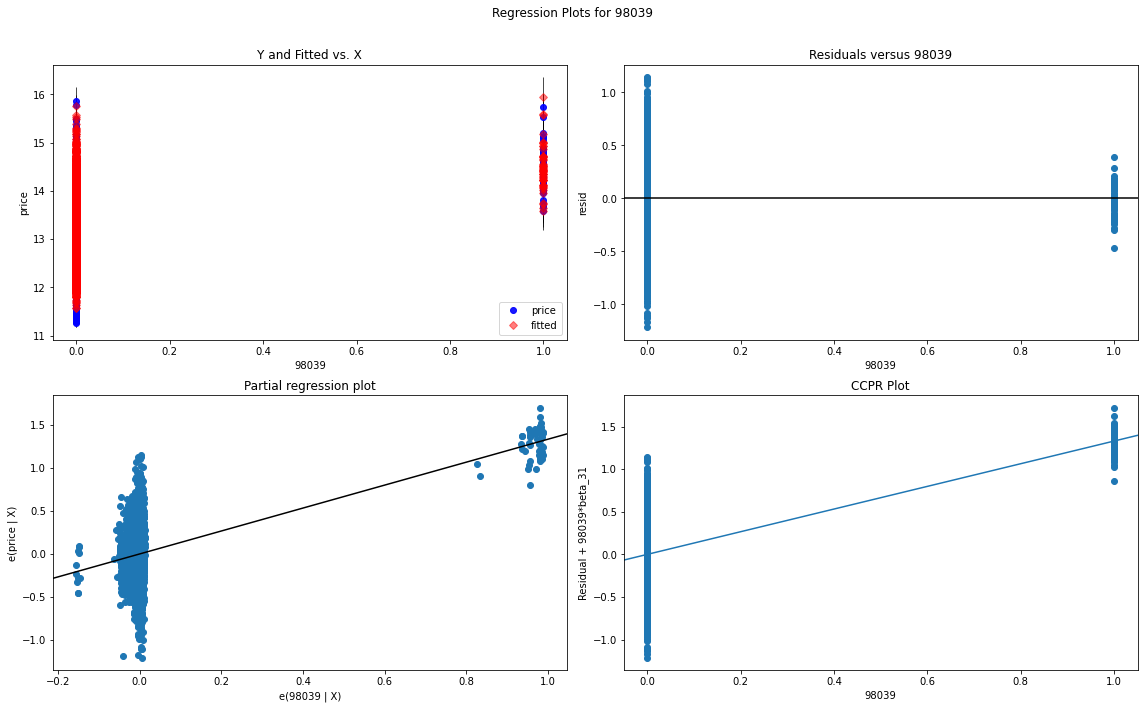

In [41]:
# Let's look at the most expensive zipcode
fig = plt.figure(figsize=(16,10))
fig = sm.graphics.plot_regress_exog(results, '98039', fig=fig)

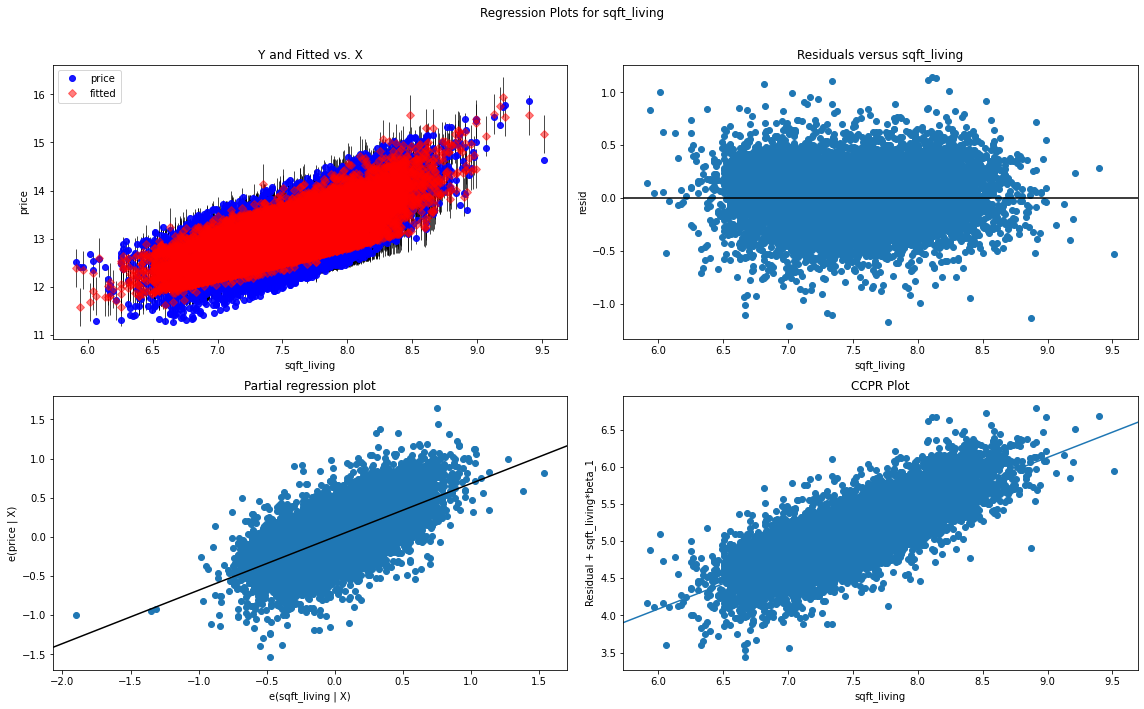

In [42]:
# Let's look at the most expensive zipcode
fig = plt.figure(figsize=(16,10))
fig = sm.graphics.plot_regress_exog(results, 'sqft_living', fig=fig)

# That's all!
Thanks for reading through this notebook! 

For more information, email at blakemcme@gmail.com or message @the_grand_blooms on github or linkedin.com/in/blakemcme

-----
-----
-----

# Extra Code

In [43]:
### Widget to adjust the number of map markers
import ipywidgets as widgets

num_pips = widgets.BoundedIntText(
 value=1000,
 min=0,
 max=20000,
 description='Enter the number of markers to display:',
 style= {'description_width': 'initial'}
 )

display(num_pips)

BoundedIntText(value=1000, description='Enter the number of markers to display:', max=20000, style=Description…

In [44]:
### Making a folium map colored by house price
pips = data.sample(num_pips.value)

lat = 47.560093
long = -122.213982
fmap = folium.Map([lat, long], zoom_start=10, tiles='CartoDB positron')

# Color map
colors = cm.LinearColormap(['lightgreen', 'yellow', 'orange', 'red'],
                           index=[250000, 500000, 1000000, 1500000],
                           vmin=250000, vmax=1500000)

# Adding Markers

for p in range(0, len(pips)):
    folium.Circle(
        location=[pips.iloc[p]['lat'], pips.iloc[p]['long']],
        fill=True,
        fill_color = colors(pips.iloc[p]['price']),
        fill_opacity=0.9,
        color=False,
        radius=100,
        legend_name='Model Predictions for Best Values',
        popup=pips.iloc[p][['price', 'bedrooms', 'bathrooms', 'id']].to_string(index=True)
        
        ).add_to(fmap)

fmap.add_child(colors)

# Displaying the map
fmap